### Modified from the ICESat-2 data tutorial

#### original authors: Scott Henderson, Anthony Arendt, David Shean, University of Washington

In [1]:
%matplotlib inline
import os
import s3fs
import xarray as xr
import h5py
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point, Polygon
import fiona
import cartopy.crs as ccrs
from mpl_toolkits.mplot3d import Axes3D

### Initial steps are disabled via `if False` to avoid accidentally running them

In [2]:
# mount S3 as if it was a file system

if False: 
    bucket = 'pangeo-data-upload-oregon'
    fs = s3fs.S3FileSystem()

# List contents of the bucket

if False:
    dataDir = 'pangeo-data-upload-oregon/icesat2/atl06'
    s3List = fs.ls(dataDir)   
    print(s3List)

# work with the first data file

if False: 
    s3File = s3List[0]
    dataFile = format(s3File.split('/')[3])

# Download an HDF5 to home directory
# If data are in your git directory: Be sure to .gitignore .h5 files so they are not pushed to GitHub.

if False:
    fs.get(s3File, dataFile)

### Using h5py to look at the dataset structure

ICESat-2 data are structured in h5 files with multiple group levels. To find what you need it helps to view these groups. 

In [6]:
dataroot = '/home/jovyan/data/icesat2/'
datafiles = os.listdir(dataroot)
source = [dataroot + df for df in datafiles]


if False:
    datafile = source[0]
    f = h5py.File(datafile,'r')
    print(type(f), '\n\n\n')

    # HDF5 behaves like a nested dictionary or if you like as a file system containing data

    groups = list(f.keys())              # groups is a list of file keys; there are 10 including 6 for the icesat2 beams

    print("Here is the top level directory of the HDF5 file:\n")
    for g in groups: print(g)            # treated as a list of key strings: The "top level directory contents"

    print('\n\n\n')

    for g in groups:
        print('---','Group: {}'.format(g), '---')
        group = f[g]                                      # 'g' is a dictionary key. Values are a list of keys
        for d in group.keys(): print('    ', group[d])

In [7]:
if False:
    toplevel=f.keys()
    a=list(toplevel)[7]

    print('The key for ground track 3-right:')
    print('     ', a, '\n')

    b = f[a].keys()

    print('The keys for gt3r:\n', b, '\n')

    c = list(b)[0]

    print('That first key, being land_ice_segments:\n', c, '\n')

    print('the keys for land_ice_segments:')
    print(f[a][c].keys())

    d=list(f[a][c]['h_li'])[0]

    print('the first land ice height: \n', d, '\n')

    is_h = list(f[a][c]['h_li'])
    is_lat = list(f[a][c]['latitude'])
    is_lon = list(f[a][c]['longitude'])
    print(len(is_h), len(is_lat), len(is_lon))
    plt.plot(is_h)


In [8]:
f.close()

### Enter xarray

Let's use gt3r/land_ice_segments.


There were two files that proved defective, were deleted (both small). For the record:

* `/home/jovyan/data/icesat2/ATL06_20190130075041_05020206_001_01.h5`
* `/home/jovyan/data/icesat2/ATL06_20190207073402_06240206_001_01.h5`

In [9]:
ds = xr.open_dataset(source[2],group='/gt3r/land_ice_segments')
print(ds)

<xarray.Dataset>
Dimensions:                (delta_time: 6165)
Coordinates:
  * delta_time             (delta_time) datetime64[ns] 2018-11-15T22:46:37.277305940 ... 2018-11-15T22:47:15.535761312
    latitude               (delta_time) float64 ...
    longitude              (delta_time) float64 ...
Data variables:
    atl06_quality_summary  (delta_time) int8 ...
    h_li                   (delta_time) float32 ...
    h_li_sigma             (delta_time) float32 ...
    segment_id             (delta_time) float64 ...
    sigma_geo_h            (delta_time) float32 ...
Attributes:
    Description:  The land_ice_height group contains the primary set of deriv...
    data_rate:    Data within this group are sparse.  Data values are provide...


/srv/conda/envs/notebook/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


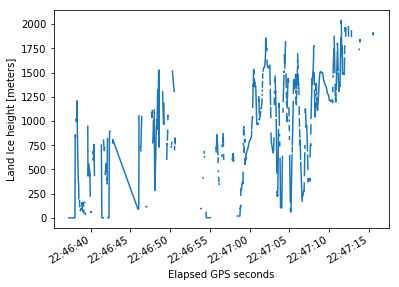

In [10]:
ds.h_li.plot()

### Convert to Pandas dataframe

In [11]:
df = ds.to_dataframe()
df.head(6)

,atl06_quality_summary,h_li,h_li_sigma,latitude,longitude,segment_id,sigma_geo_h
delta_time,,,,,,,
2018-11-15 22:46:37.277305940,0,0.516759,0.015562,57.075838,-134.292057,317136.0,0.664225
2018-11-15 22:46:37.280116040,0,0.469451,0.015947,57.076018,-134.292088,317137.0,0.583079
2018-11-15 22:46:37.282997796,0,0.439790,0.017407,57.076202,-134.292119,317138.0,0.559209
2018-11-15 22:46:37.285796296,0,0.391246,0.015143,57.076382,-134.292149,317139.0,0.452374
2018-11-15 22:46:37.288596484,0,0.351077,0.016054,57.076561,-134.292179,317140.0,0.549744
2018-11-15 22:46:37.291309648,0,0.421774,0.017310,57.076734,-134.292208,317141.0,0.433003


## Make a simple 3D scatter plot

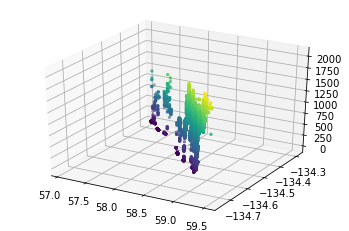

In [12]:
f = plt.figure()
ax3D = f.add_subplot(111, projection='3d')
sc = ax3D.scatter(df['latitude'], df['longitude'], df['h_li'], c=df['h_li'], marker='.')

## Convert the Pandas dataframe to a Geopandas dataframe

This mean the latitude and longitude columns are converted from just numbers into a geometry so Python knows where the data are in space.

In [13]:
df['geometry'] = list(zip(df['longitude'], df['latitude']))
df['geometry'] = df['geometry'].apply(Point)
gdf = gpd.GeoDataFrame(df)
df.head()

,atl06_quality_summary,h_li,h_li_sigma,latitude,longitude,segment_id,sigma_geo_h,geometry
delta_time,,,,,,,,
2018-11-15 22:46:37.277305940,0,0.516759,0.015562,57.075838,-134.292057,317136.0,0.664225,POINT (-134.2920568418402 57.07583842784263)
2018-11-15 22:46:37.280116040,0,0.469451,0.015947,57.076018,-134.292088,317137.0,0.583079,POINT (-134.292087720185 57.07601805728899)
2018-11-15 22:46:37.282997796,0,0.439790,0.017407,57.076202,-134.292119,317138.0,0.559209,POINT (-134.2921189793639 57.07620243069638)
2018-11-15 22:46:37.285796296,0,0.391246,0.015143,57.076382,-134.292149,317139.0,0.452374,POINT (-134.2921490735631 57.07638150470106)
2018-11-15 22:46:37.288596484,0,0.351077,0.016054,57.076561,-134.292179,317140.0,0.549744,POINT (-134.2921790745613 57.07656058416076)


### make a simple map

* get a geojson file with US state polygons
* use Cartopy to make a very simple map

In [14]:
states_url = 'http://eric.clst.org/assets/wiki/uploads/Stuff/gz_2010_us_040_00_5m.json'
states_gdf = gpd.read_file(states_url)

/srv/conda/envs/notebook/lib/python3.6/site-packages/matplotlib/colors.py:512: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


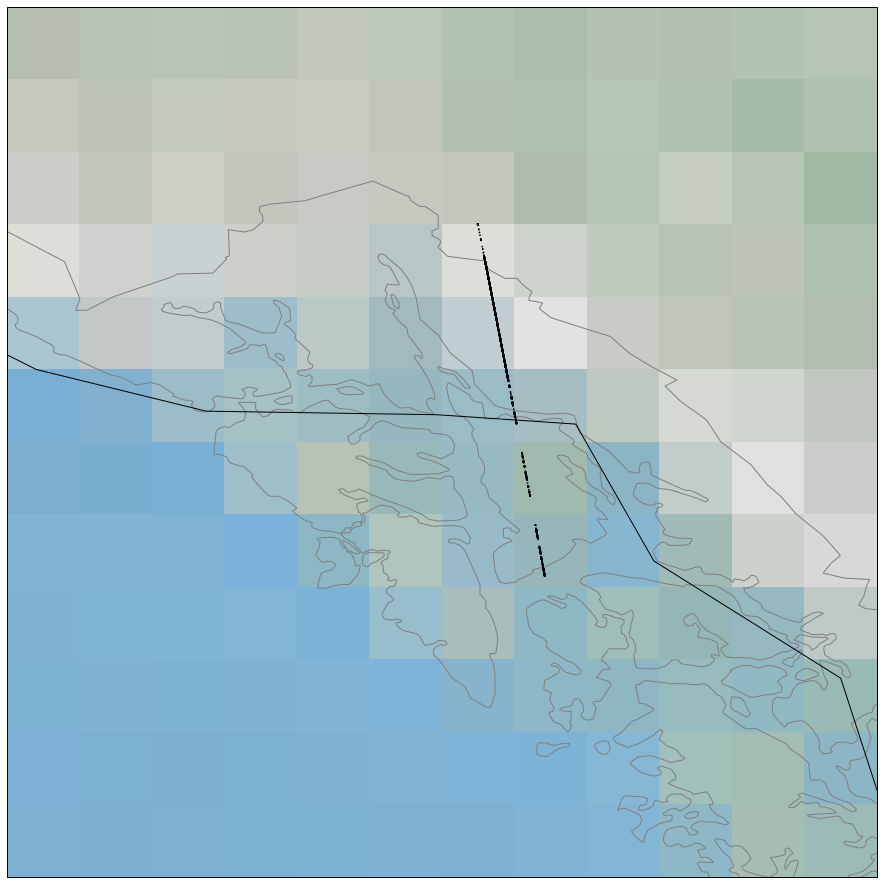

In [15]:
fig = plt.figure(figsize=(16, 16))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-138,-132, 55, 61])
ax.stock_img()
states_gdf.plot(ax=ax, facecolor='none', edgecolor='gray')
gdf.plot(ax=ax, column='h_li', cmap='inferno', markersize=.5)
ax.coastlines()

CPU times: user 6min 22s, sys: 3.8 s, total: 6min 26s
Wall time: 8min 3s


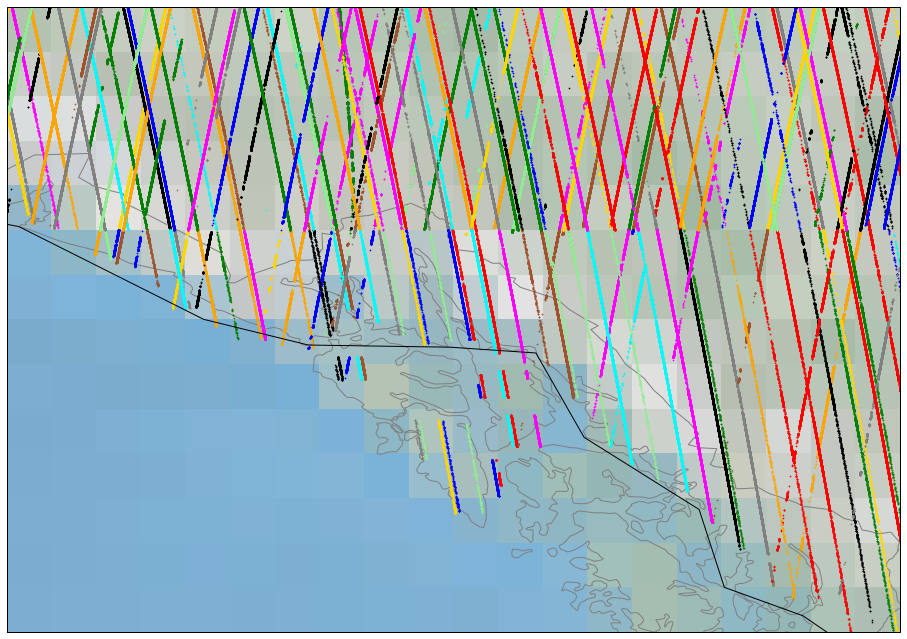

In [31]:
%%time

# create a geopandas data frame from state outlines for some added map context; particularly coastline
states_url = 'http://eric.clst.org/assets/wiki/uploads/Stuff/gz_2010_us_040_00_5m.json'
states_gdf = gpd.read_file(states_url)

fig = plt.figure(figsize=(16, 16))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-140,-130, 55, 62])
ax.stock_img()
states_gdf.plot(ax=ax, facecolor='none', edgecolor='gray')
ax.coastlines()

c=['sienna', 'gold', 'red', 'orange', 'lightgreen', 'green', 'cyan', 'blue', 'fuchsia', 'grey', 'black']
nc = len(c)

fi0 = 0
fi1 = len(source)
for i in range(fi0, fi1):
    # print(i, source[i])
    ds = xr.open_dataset(source[i],group='/gt3r/land_ice_segments')
    df = ds.to_dataframe()
    df['geometry'] = list(zip(df['longitude'], df['latitude']))
    df['geometry'] = df['geometry'].apply(Point)
    gdf = gpd.GeoDataFrame(df)
    gdf.plot(ax=ax, color=c[i%nc], markersize=.5)    # see original for column/cmap combo to color
    ds.close()


In [16]:
for i in range(5):
    ds = xr.open_dataset(source[i],group='/gt3r/land_ice_segments')
    print(ds.latitude[0:3].values, ds.latitude[-3:].values)

[59.50737823 59.5084509  59.51739125] [68.59589141 68.78973375 69.37311295]
[59.47205081 59.47185294 59.46591302] [59.45447485 57.05335567 56.96818242]
[57.07583843 57.07601806 57.07620243] [59.50356506 59.50374004 59.50392091]
[59.50242709 59.50224843 59.50206977] [55.39450809 55.39432909 55.39415009]
[56.93177353 56.93767554 56.94232621] [59.4830388  59.48321761 59.50018045]


In [17]:
if False: 
    fi0 = 0
    fi1 = len(source)
    jiftrax = []
    for i in range(fi0, fi1):
        ds = xr.open_dataset(source[i],group='/gt3r/land_ice_segments')
        if ds.latitude[0].values < 59.6 and ds.latitude[-1].values < 59.6:
            if ds.longitude[0] > -136.:
                if ds.longitude[0] < -133.5:
                    jiftrax.append(i)
    print(jiftrax)

2 /home/jovyan/data/icesat2/ATL06_20181115223845_07380102_001_01.h5


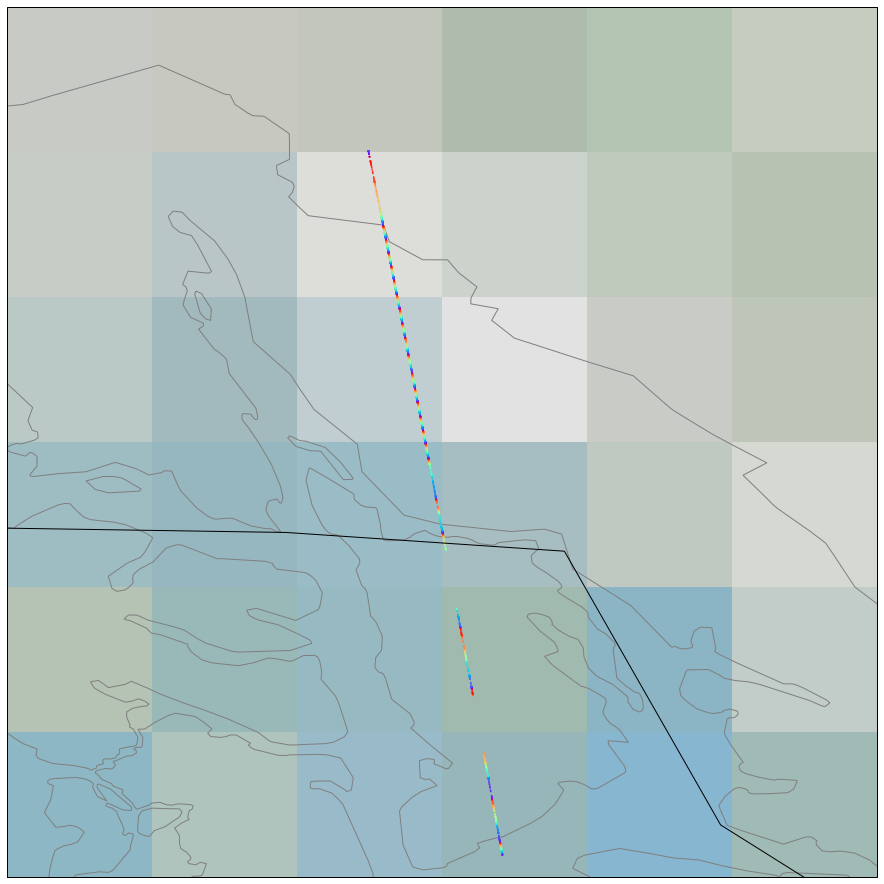

In [53]:
# all: jiftrax = [1, 2, 4, 33, 44, 51, 70, 94, 99, 117, 134, 143, 158, 161, 165, 192, 204, 206, 207, 210]
jiftrax = [2, 44, 51, 70, 99, 134, 143, 158, 204, 206]

# create a geopandas data frame from state outlines for some added map context; particularly coastline
states_url = 'http://eric.clst.org/assets/wiki/uploads/Stuff/gz_2010_us_040_00_5m.json'
states_gdf = gpd.read_file(states_url)

# background plot
fig = plt.figure(figsize=(16, 16))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-136,-133, 57, 60])
ax.stock_img()
states_gdf.plot(ax=ax, facecolor='none', edgecolor='gray')
ax.coastlines()

c=['red', 'orange', 'chocolate', 'lightgreen', 'green', 'cyan', 'lightblue', 'blue', 'magenta', 'white', 'black']
nc = len(c)

# for i in range(len(jiftrax)):
for i in range(1):
    j = jiftrax[i]
    print(j, source[j])
    ds = xr.open_dataset(source[j],group='/gt3r/land_ice_segments')
    df = ds.to_dataframe()
    df['geometry'] = list(zip(df['longitude'], df['latitude']))
    df['geometry'] = df['geometry'].apply(Point)
    gdf = gpd.GeoDataFrame(df)
    # gdf.plot(ax=ax, color=c[i%nc], markersize=.5)    # see original for column/cmap combo to color
    gdf.plot(ax=ax, cmap=plt.cm.rainbow, c=gdf.h_li.values, markersize=.5)    # see original for column/cmap combo to color; clim=[a,b] also possible
    ds.close()

In [54]:
type(gdf.h_li)

pandas.core.series.Series

In [55]:
# dir(gdf.h_li)

In [50]:
gdf.h_li.values

array([4.9045932e-01, 4.3480089e-01, 4.9036998e-01, ..., 8.9497485e+02,
       1.4192646e+03, 1.8903267e+03], dtype=float32)

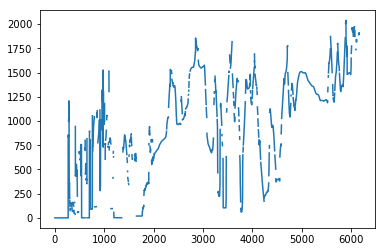

In [56]:
plt.plot(gdf.h_li.values)